<img src="NotebookAddons/blackboard-banner.jpg" width="100%" />
<font face="Calibri">
<br>
<font size="7"> <b> GEOS 657: Microwave Remote Sensing <b> </font>

<font size="5"> <b>Lab 7: Deep Learning in Earth Observation: Demo Exercise </b> </font>

<br>
<font size="4"> <b> Lichao Mou, German Aerospace Center; Xiaoxiang Zhu, German Aerospace Center & Technical University Munich </b> <br>
</font>

<img src="NotebookAddons/dlr-logo-png-transparent.png" width="170" align="right" border="2"/> <font size="3"> This Lab introduces you to the basic concepts of Deep Learning in Earth Observation. Specifically, it uses the simple example of learning the temporal pattern of a cosine curve to demonstrate the concepts of Recurrent Neural Networks (RNNs). The lab let's you experiment with several hyper-parameters needed for training Deep Learning Networks such as RNNs, CNNs, or similar.
    
We will again use a **Jupyter Notebook** framework implemented within the Amazon Web Services (AWS) cloud to work on this exercise. This Lab is part of the UAF course <a href="https://radar.community.uaf.edu/" target="_blank">GEOS 657: Microwave Remote Sensing</a>. It will introduce the following data analysis concepts:

- How to set up a recurrent deep network within the Python-based <i>keras/tensorflow</i> environment
- How to create an LSTM (long-term/short-term memory) recurrent network 
- How to optimize hyper-parameters when training a deep neural network
</font>

<font size="4"> <font color='rgba(200,0,0,0.2)'> <b>There are no Homework assignments associated with this Notebook </b> </font>
</font>
<br>
<hr>

<font face="Calibri" size="5" color="red"> <b>Important Note about JupyterHub</b> </font>
<br><br>
<font face="Calibri" size="3"> <b>Your JupyterHub server will automatically shutdown when left idle for more than 1 hour. Your notebooks will not be lost but you will have to restart their kernels and re-run them from the beginning. You will not be able to seamlessly continue running a partially run notebook.</b> </font>
<hr>

# Predict a cosine wave using RNNs

* A simple tutorial on LSTM and GRU to perdict a trigonometric wave.

* Data noise can be added to test the robustness of the model.

* Hyperparamters of the RNNs can be tweaked


## Import dependencies


In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, GRU, TimeDistributed
from keras.optimizers import RMSprop

Using TensorFlow backend.


## Get cosine data

Data to train and evaluate the RNN:

* Start, end and step define the range of the data series.
* Sequence length defines the series to look back to train the model
* Noisy data can be added to make the training data imperfect.

### Write a function to define training data:

In [2]:
# Takes: starting point, end point, number of steps between points
# number of steps to backpropagate through time, and noise to create imperfect data
# Returns: X,Y data


def cosine_data(start, end, step, sequence_length, noise_level=0):

    t = np.arange(start, end, step)
    cosine = np.cos(2 * np.pi * t) + noise_level * \
        np.random.normal(0, 1, np.shape(t))
    cosine = cosine.reshape((cosine.shape[0], 1))

    dX, dY = [], []
    for i in range(len(cosine) - 2*sequence_length):
        dX.append(cosine[i:i + sequence_length])
        dY.append(cosine[i + sequence_length:i + 2*sequence_length])
    dataX = np.array(dX)
    dataY = np.array(dY)
    return dataX, dataY


## Create a LSTM model

* Linear activation
* Loss in mean squared error

### Write a function that creates an LSTM model:

In [3]:
# Takes: number of neurons to train a GRU network, number of features to predict, and learning_rate
# Returns: model for training


def LSTM_(hidden_neurons, feature_count, learning_rate):
    model = Sequential()
    model.add(LSTM(input_dim=feature_count,
                   output_dim=hidden_neurons, return_sequences=True))
    model.add(TimeDistributed(Dense(feature_count)))
    model.add(Activation('linear'))
    optimizer = RMSprop(lr=learning_rate)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer, metrics=['mse'])
    return model


## Create a GRU model

* Linear activation
* Get loss using a mean squared error

### Write a function that creates a GRU model:

In [4]:
# Takes number of neurons to train a GRU network, number of features to predict, and learning_rate
# Returns: model for training


def GRU_(hidden_neurons, feature_count, learning_rate):
    model = Sequential()
    model.add(GRU(input_dim=feature_count,
                  output_dim=hidden_neurons, return_sequences=True))
    model.add(TimeDistributed(Dense(feature_count)))
    model.add(Activation('linear'))
    optimizer = RMSprop(lr=learning_rate)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer, metrics=['mse'])
    return model

### Write a function to train a RNN model:

In [5]:
# Takes: load RNN model, X cosine train data, Y cosine train data,
# number of samples to be propagated through the network, and
# number of time dataset is processed
# Returns: training and validation loss


def train_cosine(model, dataX, dataY, batch_size, epoch_count):

    history = model.fit(dataX, dataY, batch_size=batch_size,
                        epochs=epoch_count, validation_split=0.05)
    loss_history = history.history['loss']
    loss_history = np.array(loss_history)
    #np.savetxt("loss_history.txt", numpy_loss_history, delimiter=",")
    val_loss_history = history.history['val_loss']
    val_loss_history = np.array(val_loss_history)
    #np.savetxt("val_loss_history.txt", numpy_loss_history, delimiter=",")
    loss = history.history['loss']
    loss_val = history.history['val_loss']
    plt.rcParams.update({'font.size': 18})
    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(loss)
    plt.plot(loss_val)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

    return loss_history, val_loss_history

### Write a function to run RNN code:

In [6]:
# Takes: number of Epochs, noise level in training data, sequence length available to train a RNN,
# learning_rate, batch_size, nb_units, boolean if results should be plotted
# Return: Loss and Plot


def test_cosine(EPOCHS, noise_level=0.3, sequence_length=100, learning_rate=1e-3, batch_size=16, nb_units=32, plot_results=False):

    dataX, dataY = cosine_data(
        0.0, 10, 0.02, sequence_length, noise_level)  # 4.0
    # create and fit the LSTM network
    print('creating model...')

    # Choose RNN to train
    model = LSTM_(nb_units, 1, learning_rate)
    #model = GRU_(nb_units, 1, learning_rate)

    # Train RNN model
    tr_loss, val_loss = train_cosine(model, dataX, dataY, batch_size, EPOCHS)

    # now test
    dataX1, dataY1 = cosine_data(15.0, 21.0, 0.02, sequence_length)
    predict = model.predict(dataX1)
    if plot_results:
        plot_RNN_results(dataX, dataX1, dataY1, predict, sequence_length)

    return tr_loss, val_loss

### Write a function to plot RNN results:

In [7]:
def plot_RNN_results(dataX, dataX1, dataY1, predict, sequence_length):
     # now plot
    nan_array = np.empty((sequence_length - 1))
    nan_array.fill(np.nan)
    nan_array2 = np.empty(sequence_length)
    nan_array2.fill(np.nan)
    ind = np.arange(2*sequence_length)
    plt.rcParams.update({'font.size': 18})
    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(1, 1, 1)
    #fig, ax = plt.subplots()
    for i in range(0, sequence_length, sequence_length):
        forecasts = np.concatenate(
            (nan_array, dataX1[i, -1:, 0], predict[i, :, 0]))
        ground_truth = np.concatenate(
            (nan_array, dataX1[i, -1:, 0], dataY1[i, :, 0]))
        network_input = np.concatenate((dataX[i, :, 0], nan_array2))

        ax.plot(ind, network_input, 'b-x', label='Network input')
        ax.plot(ind, forecasts, 'r-x', label='Many to many model forecast')
        ax.plot(ind, ground_truth, 'g-x', label='Ground truth')

        plt.xlabel('t')
        plt.ylabel('cos(t)')
        plt.title('Cosine Many to Many Forecast')
        plt.legend(bbox_to_anchor=(1.5, 0.5), loc='center', ncol=1)
        #plt.savefig(os.getcwd() + "cosine_wave" + str(i) + '.png')
        plt.show()

creating model...
Instructions for updating:
Colocations handled automatically by placer.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=32)`
  


Instructions for updating:
Use tf.cast instead.
Train on 285 samples, validate on 15 samples
Epoch 1/10
285/285 [==============================] - 2s 5ms/step - loss: 2.4263 - mean_squared_error: 2.4263 - val_loss: 0.5940 - val_mean_squared_error: 0.5940
Epoch 2/10
285/285 [==============================] - 1s 4ms/step - loss: 0.8995 - mean_squared_error: 0.8995 - val_loss: 0.1900 - val_mean_squared_error: 0.1900
Epoch 3/10
285/285 [==============================] - 1s 4ms/step - loss: 0.2090 - mean_squared_error: 0.2090 - val_loss: 0.1714 - val_mean_squared_error: 0.1714
Epoch 4/10
285/285 [==============================] - 1s 4ms/step - loss: 0.2474 - mean_squared_error: 0.2474 - val_loss: 0.2764 - val_mean_squared_error: 0.2764
Epoch 5/10
285/285 [==============================] - 1s 4ms/step - loss: 0.2385 - mean_squared_error: 0.2385 - val_loss: 0.2232 - val_mean_squared_error: 0.2232
Epoch 6/10
285/285 [==============================] - 1s 4ms/step - loss: 0.2172 - mean_squared_e

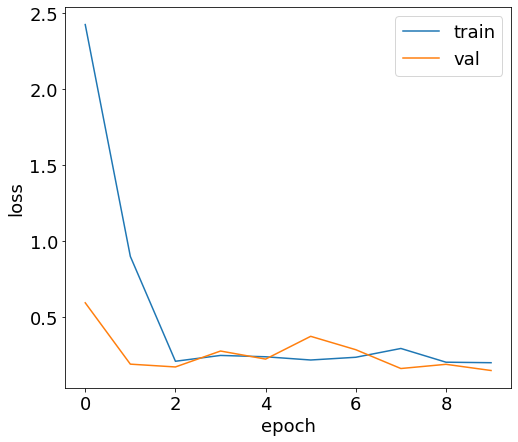

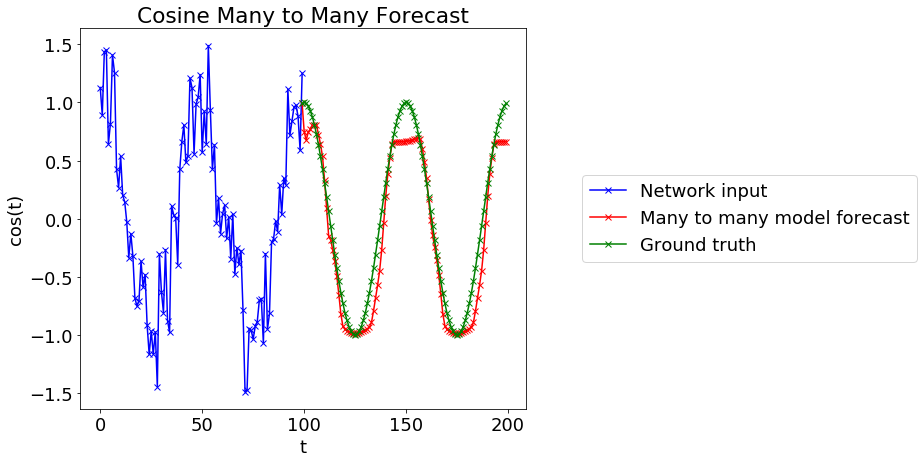

tr_loss: [2.42625544 0.89954727 0.20895642 0.24738784 0.23851915 0.21722265
 0.23526611 0.29320876 0.20282335 0.1994052 ]
val_loss: [0.59400219 0.18998013 0.17144467 0.27636746 0.22323073 0.37317207
 0.28505141 0.16115393 0.18881512 0.14809561]
creating model...
Train on 285 samples, validate on 15 samples
Epoch 1/10
285/285 [==============================] - 2s 6ms/step - loss: 0.1772 - mean_squared_error: 0.1772 - val_loss: 0.1216 - val_mean_squared_error: 0.1216
Epoch 2/10
285/285 [==============================] - 1s 4ms/step - loss: 0.1200 - mean_squared_error: 0.1200 - val_loss: 0.1143 - val_mean_squared_error: 0.1143
Epoch 3/10
285/285 [==============================] - 1s 4ms/step - loss: 0.1176 - mean_squared_error: 0.1176 - val_loss: 0.1178 - val_mean_squared_error: 0.1178
Epoch 4/10
285/285 [==============================] - 1s 4ms/step - loss: 0.1164 - mean_squared_error: 0.1164 - val_loss: 0.1243 - val_mean_squared_error: 0.1243
Epoch 5/10
285/285 [========================

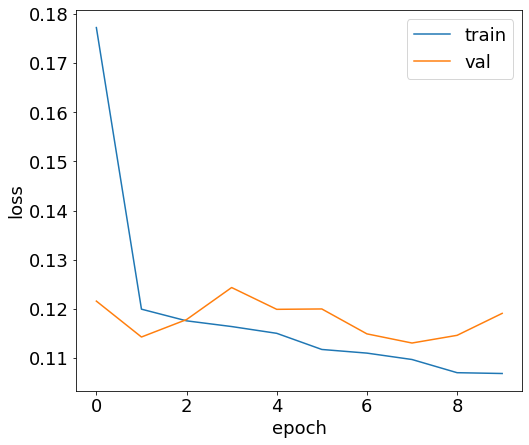

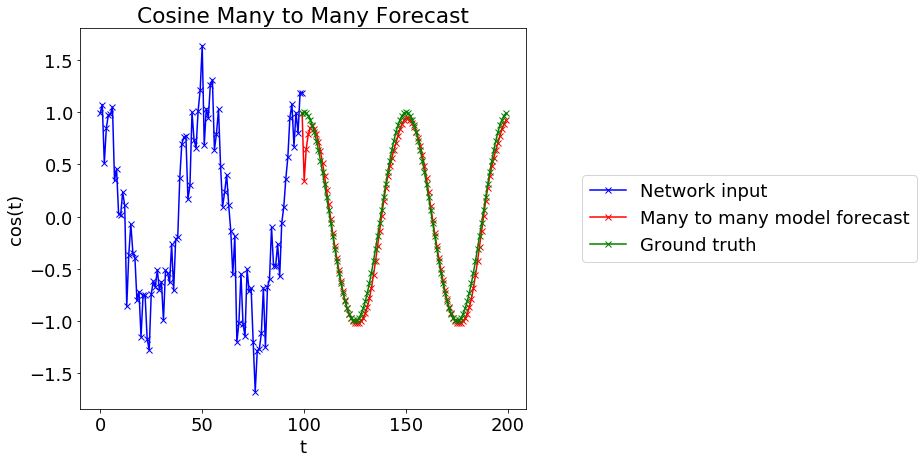

tr_loss: [0.17721575 0.11995061 0.11757683 0.11641488 0.11503751 0.11175459
 0.1110134  0.10971228 0.1070311  0.10686598]
val_loss: [0.12158811 0.11428726 0.11783313 0.12434942 0.11991632 0.11999249
 0.11492739 0.11306509 0.11463011 0.11909766]
creating model...
Train on 285 samples, validate on 15 samples
Epoch 1/10
285/285 [==============================] - 2s 6ms/step - loss: 0.3443 - mean_squared_error: 0.3443 - val_loss: 0.2236 - val_mean_squared_error: 0.2236
Epoch 2/10
285/285 [==============================] - 1s 4ms/step - loss: 0.1663 - mean_squared_error: 0.1663 - val_loss: 0.1359 - val_mean_squared_error: 0.1359
Epoch 3/10
285/285 [==============================] - 1s 4ms/step - loss: 0.1349 - mean_squared_error: 0.1349 - val_loss: 0.1220 - val_mean_squared_error: 0.1220
Epoch 4/10
285/285 [==============================] - 1s 4ms/step - loss: 0.1320 - mean_squared_error: 0.1320 - val_loss: 0.1169 - val_mean_squared_error: 0.1169
Epoch 5/10
285/285 [========================

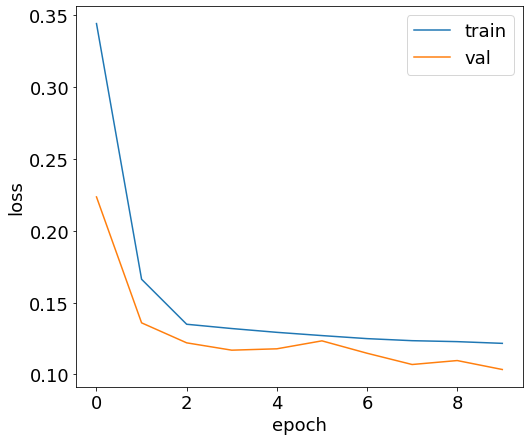

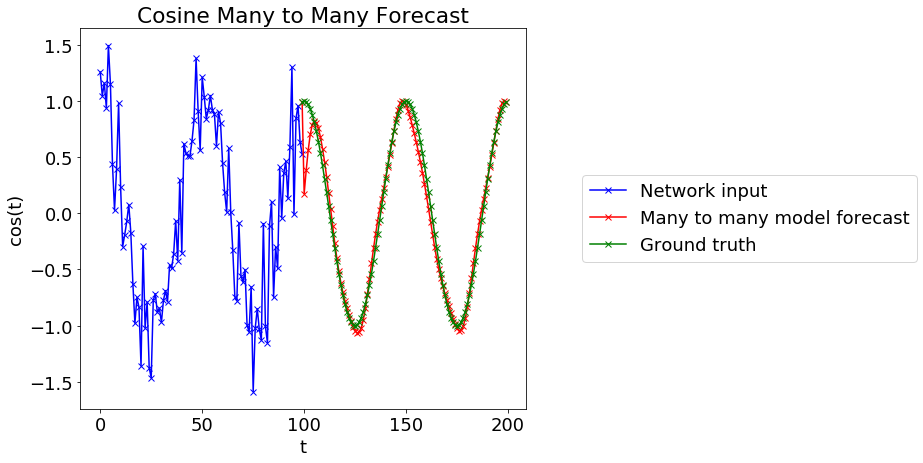

tr_loss: [0.3443138  0.16628203 0.1349449  0.13196461 0.1293191  0.12705864
 0.12494084 0.12350836 0.12284326 0.12164858]
val_loss: [0.22360532 0.13593595 0.12200713 0.11689688 0.11785008 0.12339058
 0.11476835 0.1069187  0.10967136 0.1034397 ]
creating model...
Train on 285 samples, validate on 15 samples
Epoch 1/10
285/285 [==============================] - 2s 6ms/step - loss: 0.7136 - mean_squared_error: 0.7136 - val_loss: 0.7629 - val_mean_squared_error: 0.7629
Epoch 2/10
285/285 [==============================] - 1s 3ms/step - loss: 0.6750 - mean_squared_error: 0.6750 - val_loss: 0.7263 - val_mean_squared_error: 0.7263
Epoch 3/10
285/285 [==============================] - 1s 3ms/step - loss: 0.6422 - mean_squared_error: 0.6422 - val_loss: 0.6917 - val_mean_squared_error: 0.6917
Epoch 4/10
285/285 [==============================] - 1s 3ms/step - loss: 0.6109 - mean_squared_error: 0.6109 - val_loss: 0.6581 - val_mean_squared_error: 0.6581
Epoch 5/10
285/285 [========================

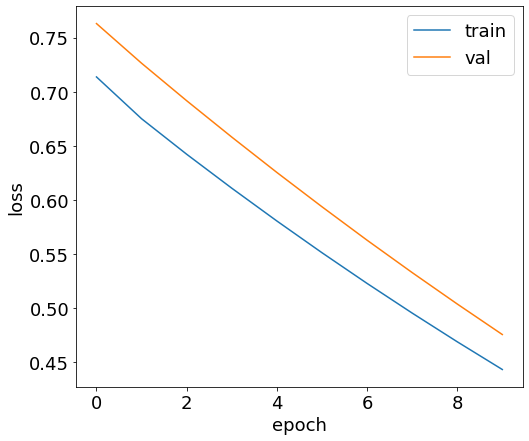

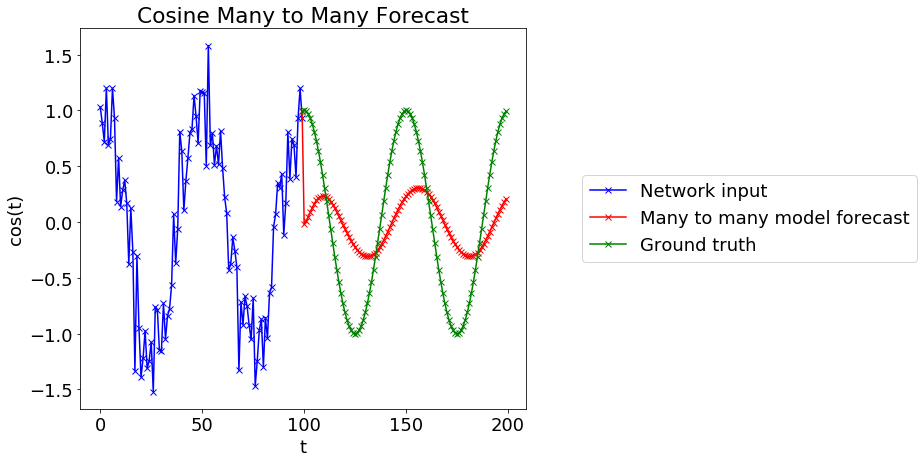

tr_loss: [0.71363351 0.67500808 0.64221509 0.61085605 0.58056211 0.55126019
 0.52290358 0.49550244 0.46897921 0.44334838]
val_loss: [0.76292586 0.72628659 0.69165587 0.65807623 0.62540615 0.59370905
 0.56282884 0.53292191 0.50388384 0.47565544]
creating model...
Train on 285 samples, validate on 15 samples
Epoch 1/10
285/285 [==============================] - 2s 6ms/step - loss: 0.5481 - mean_squared_error: 0.5481 - val_loss: 0.5769 - val_mean_squared_error: 0.5769
Epoch 2/10
285/285 [==============================] - 1s 3ms/step - loss: 0.5444 - mean_squared_error: 0.5444 - val_loss: 0.5736 - val_mean_squared_error: 0.5736
Epoch 3/10
285/285 [==============================] - 1s 3ms/step - loss: 0.5411 - mean_squared_error: 0.5411 - val_loss: 0.5705 - val_mean_squared_error: 0.5705
Epoch 4/10
285/285 [==============================] - 1s 3ms/step - loss: 0.5378 - mean_squared_error: 0.5378 - val_loss: 0.5674 - val_mean_squared_error: 0.5674
Epoch 5/10
285/285 [========================

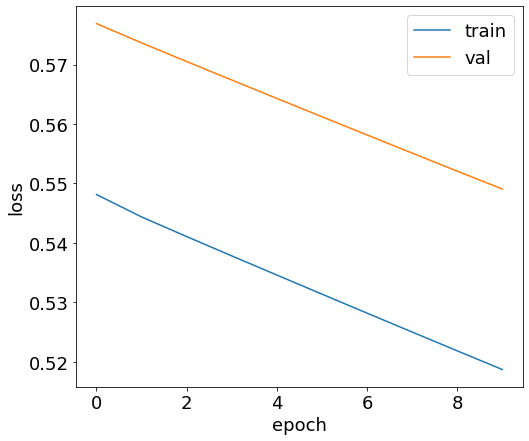

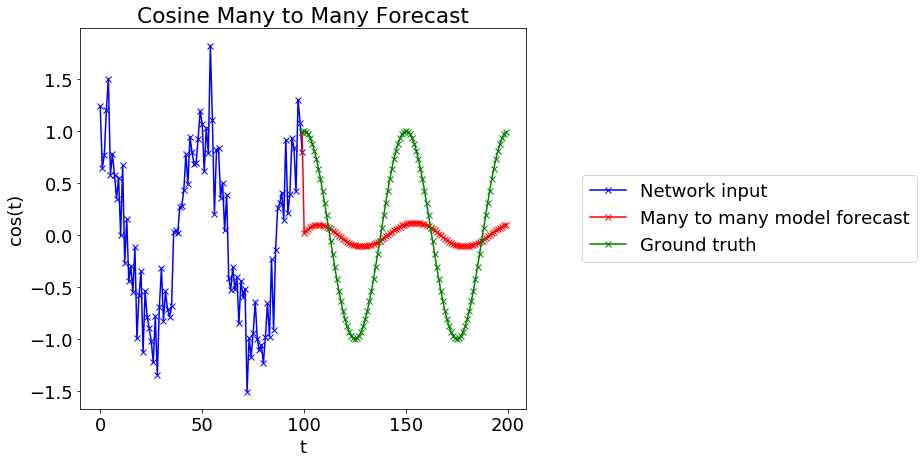

tr_loss: [0.5481297  0.54436411 0.54105786 0.53780855 0.5345848  0.53137512
 0.52818213 0.5250012  0.52183656 0.51869433]
val_loss: [0.57689136 0.57364464 0.57050246 0.56739402 0.56429738 0.56122243
 0.55815321 0.55510259 0.55206478 0.54905218]


"\n# hyperparameter: 4) nb_units\nnb_units_range = [8, 16, 32, 64, 128]\nfor nu in nb_units_range:\n    tr_loss, val_loss = test_cosine(EPOCHS = nb_epochs, nb_units=nu, plot_results=True)\n    print('tr_loss:', tr_loss)\n    print('val_loss:', val_loss)\n"

In [8]:
nb_epochs = 10
noise_level = 0.0
sequence_length = 100
'''
learning_rate = 1e-3  # 1e-1, 1e-2, 1e-3, 1e-4, 1e-5
batch_size = 16  # 1, 2, 4, 8, 16
nb_units = 32  # 8, 16, 32, 64, 128

_, _ = test_cosine(EPOCHS = nb_epochs, noise_level =noise_level, 
                   plot_results=True)
'''
# try with different noise
'''
noise_level_range = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
for nl in noise_level_range:
    tr_loss, val_loss = test_cosine(EPOCHS = nb_epochs, noise_level=nl)
    print('tr_loss:', tr_loss)
    print('val_loss:', val_loss)
'''

# hyperparameter: 1) lr
learning_rate_range = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
for lr in learning_rate_range:
    tr_loss, val_loss = test_cosine(EPOCHS = nb_epochs, learning_rate=lr, plot_results=True)
    print('tr_loss:', tr_loss)
    print('val_loss:', val_loss)

'''
# hyperparameter: 2) batch size
batch_size_range = [2, 4, 8, 16, 32]
for bs in batch_size_range:
    tr_loss, val_loss = test_cosine(EPOCHS = nb_epochs, batch_size=bs, plot_results=True)
    print('tr_loss:', tr_loss)
    print('val_loss:', val_loss)
'''
'''
# hyperparameter: 3) sequence length
sequence_length_range = [20, 50, 100, 200, 500]
for sl in sequence_length_range:
    tr_loss, val_loss = test_cosine(EPOCHS = nb_epochs, sequence_length=sl, plot_results=True)
    print('tr_loss:', tr_loss)
    print('val_loss:', val_loss)
'''
'''
# hyperparameter: 4) nb_units
nb_units_range = [8, 16, 32, 64, 128]
for nu in nb_units_range:
    tr_loss, val_loss = test_cosine(EPOCHS = nb_epochs, nb_units=nu, plot_results=True)
    print('tr_loss:', tr_loss)
    print('val_loss:', val_loss)
'''
